In [289]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RepeatedEditedNearestNeighbours


import catboost
from catboost import CatBoostClassifier

In [290]:
df_original = pd.read_excel("teste2.xlsx")

In [291]:
pd.set_option('display.max_columns', None) #Consigo ver todas as colunas, sem os "três pontinhos" no meio
df_original.head()

,X,APOLICE,Flag_apo_anul,PRCOMANL,var_premio_ap_ult_rn,conta_mediacao,entidade,NIF,ENTITYID,saldo_cliente,LISTA_NEGRA,registado_Area_priv,Tipo_Entidade,Carta,idade,RAMO,brandid,Marca,sitapol,MOTANULA,Motivo_Anulacao,Motivo_Anulacao_,flag_anul_RN,MODO_RENOVACAO,DTEMISS,DTINICIO,DTINANO,DTTERMO,DTANUL,DTEFEANU,dias_vigor,anuidades,canal,protocolo,Tipo_Fraccionamento,Forma_Pagamento,bonus,Sin_AU,ultimo_sinistro_AU,produto_marca,PRODUTO,Tipo_seguro,VMATRIC,prcomanl_ob,ano_construcao,SITOBJ,TPVIAT
0,1,900000003,0,204.66,-1.71,411101,4001000010,163967415,168435,1863.8575,0,1,Particular,30.0,48.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-06,2007-11-29,2019-11-29,2020-11-29,NaT,NaT,4506,12,CALL CENTER,NaN,1,A,8,1.0,2008-03-04,Essencial,RC Essencial,RC,89-LN-66,205.66,2011,V,01A
1,2,900000033,0,132.87,-17.10,411101,4001000024,225366983,168449,2117.2189,0,1,Particular,21.0,40.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-07,2007-11-01,2019-11-01,2020-11-01,NaT,NaT,4534,12,CALL CENTER,NaN,1,A,8,NaN,NaT,Essencial,RC Essencial,RC,02-RA-19,133.87,2013,V,01A
2,3,900000037,0,145.55,2.35,411101,4001000021,122585330,168446,1796.4838,0,1,Particular,36.0,61.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-07,2007-11-05,2019-11-05,2020-11-05,NaT,NaT,4530,12,CALL CENTER,16.0,1,A,8,NaN,NaT,Essencial,RC Essencial,RC,34-OX-12,146.55,2014,V,01A
3,4,900000223,0,137.89,1.19,411101,4001000078,177579226,168499,52.9745,0,0,Particular,35.0,55.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-08,2007-10-08,2019-10-08,2020-10-08,NaT,NaT,4558,12,CALL CENTER,NaN,1,A,8,2.0,2019-12-08,Mulher,RC Mulher,RC,17-23-XP,138.89,2004,V,01A
4,5,900000264,0,116.52,1.07,411101,4001000085,204469821,168505,1425.6096,0,1,Particular,26.0,45.0,AU,1,OK! teleseguros,OK,NaN,NaN,NaN,0,A,2007-10-08,2007-10-16,2019-10-16,2020-10-16,NaT,NaT,4550,12,CALL CENTER,16.0,2,A,8,NaN,2015-09-17,Essencial,RC Essencial,RC,45-47-DZ,118.52,1994,V,01A


In [292]:
df = df_original.drop(['APOLICE','entidade','ENTITYID','RAMO','Carta', 'idade',
         'MOTANULA','Motivo_Anulacao','DTEMISS', 'MODO_RENOVACAO',
         'DTINICIO','DTINANO','DTTERMO','DTANUL',
         'DTEFEANU','VMATRIC','SITOBJ','TPVIAT', 'dias_vigor','ultimo_sinistro_AU','protocolo', 'sitapol', 'flag_anul_RN','Motivo_Anulacao_'], axis=1) #Retirei as colunas que não me servem

In [293]:
df['Sin_AU'] = df['Sin_AU'].replace(np.nan, 0)
df['produto_marca'] = df['produto_marca'].replace(np.nan, 0)
df['PRODUTO'] = df['PRODUTO'].replace(np.nan, 0)
df['Tipo_seguro'] = df['Tipo_seguro'].replace(np.nan, 0)

#df['idade'] = df['idade'].replace(np.nan, df['idade'].mean)
#df['Carta'] = df['Carta'].replace(np.nan, df['Carta'].mean)

#df.isna().sum()
#df.info()
#df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
#df = df[df.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]
#df = df.reset_index()



thislist = ["PRCOMANL", "var_premio_ap_ult_rn", "conta_mediacao",
            "saldo_cliente", "LISTA_NEGRA", "registado_Area_priv",
            "brandid", "anuidades", "Tipo_Fraccionamento", "bonus",
           "Sin_AU", "prcomanl_ob", "ano_construcao"]
for x in thislist:
    df[x] = pd.to_numeric(df[x], errors='coerce')
  



In [308]:
X = df.drop(['Flag_apo_anul', 'NIF'], axis=1).copy()
y = df['Flag_apo_anul'].copy()
#X.dtypes


X_encoded = pd.get_dummies(X, columns=['Tipo_Entidade',
                           'Marca',
                           'canal',
                           'Forma_Pagamento',
                           'produto_marca',
                           'PRODUTO',
                           'Tipo_seguro'])

In [296]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,  # drop the target
    y,  # just the target
    test_size=0.3,
    random_state=0)



In [297]:
renn = RepeatedEditedNearestNeighbours(
    sampling_strategy='auto', #removes only the majority class
    n_neighbors=3,    # 3 KNN
    kind_sel='all',   # All neighbouring observations should show the same class
    n_jobs=2,         # 2 processors in my laptop
    max_iter=100)     # Max iterations until stop

X_renn, y_renn = renn.fit_resample(X_train, y_train)

In [298]:
X_train.shape, X_renn.shape

((699, 44), (595, 44))

Text(0.5, 1.0, 'Original data')

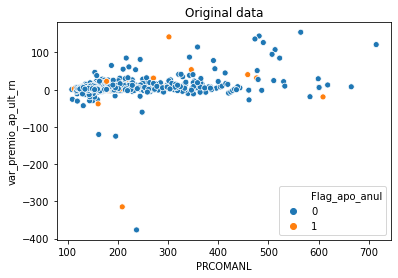

In [299]:
sns.scatterplot(data=X_train,
                x="PRCOMANL",
                y="var_premio_ap_ult_rn",
                hue=y_train)

plt.title('Original data')

Text(0.5, 1.0, 'Repeated Edited NN data')

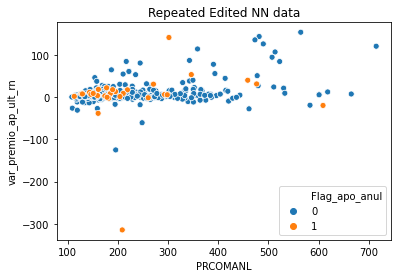

In [300]:
sns.scatterplot(data=X_renn,
                x="PRCOMANL",
                y="var_premio_ap_ult_rn",
                hue=y_renn)

plt.title('Repeated Edited NN data')

In [301]:
def Cat_boost(X_train, X_test, y_train, y_test):
    
    params = {'iterations':1000,
         'learning_rate':0.01,
         'depth':3,
         'eval_metric':'AUC',
         'verbose':200,
         'od_type':'Iter',
         'od_wait':500,
         'random_seed': 1
         }

    cat_model = CatBoostClassifier(**params)
    cat_model.fit(X_train, y_train,
             eval_set=(X_test, y_test),
             use_best_model=True
             );

    print('Train set')
    pred = cat_model.predict_proba(X_train)
    print('Cat Boost roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = cat_model.predict_proba(X_test)
    print('Cat Boost roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [302]:
def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [303]:
# evaluate performance of algorithm built with random forests
# using imbalanced dataset

run_randomForests(X_train,
                  X_test,
                  y_train,
                  y_test)

Train set
Random Forests roc-auc: 0.9575524737631185
Test set
Random Forests roc-auc: 0.7131519274376417


In [304]:
# evaluate performance of algorithm built with random forests
# using renn undersampled dataset

run_randomForests(X_renn,
                  X_test,
                  y_renn,
                  y_test)

Train set
Random Forests roc-auc: 0.9767984014209592
Test set
Random Forests roc-auc: 0.6740362811791383


In [305]:
# evaluate performance of algorithm built with cat boost
# using imbalanced dataset

Cat_boost(X_train,
          X_test,
          y_train,
          y_test)

0:	test: 0.5484694	best: 0.5484694 (0)	total: 1.58ms	remaining: 1.58s
200:	test: 0.7233560	best: 0.7261905 (195)	total: 294ms	remaining: 1.17s
400:	test: 0.7227891	best: 0.7261905 (195)	total: 592ms	remaining: 885ms
600:	test: 0.7142857	best: 0.7261905 (195)	total: 866ms	remaining: 575ms
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7261904762
bestIteration = 195

Shrink model to first 196 iterations.
Train set
Cat Boost roc-auc: 0.8869940029985007
Test set
Cat Boost roc-auc: 0.7261904761904763


In [306]:
# evaluate performance of algorithm built with cat boost
# using renn undersampled dataset

Cat_boost(X_renn,
          X_test,
          y_renn,
          y_test)

0:	test: 0.4314059	best: 0.4314059 (0)	total: 1.23ms	remaining: 1.23s
200:	test: 0.7086168	best: 0.7403628 (1)	total: 332ms	remaining: 1.32s
400:	test: 0.7040816	best: 0.7403628 (1)	total: 663ms	remaining: 990ms
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7403628118
bestIteration = 1

Shrink model to first 2 iterations.
Train set
Cat Boost roc-auc: 0.6488954262877442
Test set
Cat Boost roc-auc: 0.7403628117913832
